In [1]:
from importlib import reload
import torch
from torch.nn import functional as F
import pandas as pd
from tqdm.auto import tqdm
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import numpy as np
#Import graph based
from graph_based.utils.loader import  get_dataset
from graph_based.models.gnn.layers import GraphConvolution
from graph_based.models import resnet
from graph_based.models.hyper_models import HybridGNN
from graph_based.train import train_hybrid
from graph_based.utils.evaluate import eval_normal, eval_hybrid
#Import SSL
from co2al_method import ssl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches

In [2]:
def get_data_graph(nodes,links):
    dataset, _ , adj = get_dataset(nodes, links, nodes.shape[0]) 
    return dataset, adj

In [17]:
features = pd.read_csv("./graph_based/dataset/node_03_11_2022.csv")
links = pd.read_csv("./graph_based/dataset/link_03_11_2022.csv").to_numpy().astype(float)
links_df = pd.read_csv("./graph_based/dataset/link_03_11_2022.csv")
train_xgb = pd.read_csv("D:\AI Project\Icaller_spam_xgb\data_train_90.csv")

In [4]:
X_pool, X_gnn_test, X_xgb_pool, X_xgb_test, y_pool, y_test = train_test_split(features, train_xgb, features[:,-1],test_size=0.2, random_state= 42)
X_gnn_train, X_gnn_unlabeled, X_xgb_train, X_xgb_unlabeled, y_train, y_unlabel = train_test_split(X_pool, X_xgb_pool, y_pool, test_size=0.5, random_state= 42)


In [5]:
# dataset_train, nrm_adj_train, adjs_train = get_dataset(X_gnn_train, links, X_gnn_train.shape[0]) 
# dataset_test, nrm_adj_test, adjs_test = get_dataset(X_gnn_test, links, X_gnn_test.shape[0]) 
dataset_train, adjs_train = get_data_graph(X_gnn_train, links)
dataset_val, adj_val = get_data_graph(X_gnn_test, links)


In [6]:
nets = [resnet.ResNet(GraphConvolution,
             in_features=features.shape[1] - 2,
             cfg=[16, 16, 32, 16],
             n_residual_units=[2, 2, 2],
             hidden_layers_fc= [16,8],
             num_classes=None) for _ in range(features.shape[1] - 2)]
model_graph = HybridGNN(2, 'cuda', *nets).cuda()

c:\Users\GroooDev\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [7]:
cummulative = []

In [8]:
# model_graph, loss = train_hybrid(model_graph, dataset_train, adjs_train, 'adamw',
#                            'multilabel', 'cuda', 1e-3, 1500)
# cummulative.extend(loss)

In [9]:
# torch.save(model_graph.state_dict(), "./checkpoints/mode_grahpbased.pt")
# model_graph.load_state_dict(torch.load("mode_new.pt", map_location='cpu'))

In [10]:

# pred, f1_resnet_test, acc_resnet_test, prob = eval_hybrid(model_graph, dataset_val.data, dataset_val.targets, adj_val)
# print(acc_resnet_test)
# plt.plot(loss)

In [11]:
# XGB1 = xgb.XGBClassifier(eval_metric = "logloss",objective = "binary:logistic", booster = "gbtree", tree_method = "gpu_hist",
#                              max_depth = 4, gamma = 2, learning_rate = 0.005, n_estimators = 300, subsample = 0.7 , colsample_bytree = 0.7, min_child_weight = 4, use_label_encoder  = False )
XGB1 = xgb.XGBClassifier(objective='binary:logistic',
                        booster='gbtree',
                        colsample_bytree=1,
                        learning_rate=0.005,
                        max_depth=8,
                        min_child_weight=12,
                        scale_pos_weight=1,
                        n_estimators=3000,
                        random_state=1,
                        seed=1,
                        eta=0.3,
                        subsample=0.8,
                        tree_method='gpu_hist',
                        sampling_method='uniform')
evalset1 = [(X_xgb_train[:,1:-1], y_train), (X_xgb_test[:,1:-1], y_test)]
XGB1 = XGB1.fit(X_xgb_train[:,1:-1], y_train , eval_metric='logloss', eval_set=evalset1)
prediction_test1 = XGB1.predict(X_xgb_test[:,1:-1])
f1_xgb = f1_score(y_test,prediction_test1)
acc_xgb = accuracy_score(y_test,prediction_test1)

[0]	validation_0-logloss:0.68915	validation_1-logloss:0.68915
[1]	validation_0-logloss:0.68520	validation_1-logloss:0.68520
[2]	validation_0-logloss:0.68129	validation_1-logloss:0.68130
[3]	validation_0-logloss:0.67742	validation_1-logloss:0.67743
[4]	validation_0-logloss:0.67360	validation_1-logloss:0.67360
[5]	validation_0-logloss:0.66980	validation_1-logloss:0.66981
[6]	validation_0-logloss:0.66603	validation_1-logloss:0.66606
[7]	validation_0-logloss:0.66231	validation_1-logloss:0.66234


c:\Users\GroooDev\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[8]	validation_0-logloss:0.65862	validation_1-logloss:0.65866
[9]	validation_0-logloss:0.65498	validation_1-logloss:0.65502
[10]	validation_0-logloss:0.65136	validation_1-logloss:0.65140
[11]	validation_0-logloss:0.64779	validation_1-logloss:0.64784
[12]	validation_0-logloss:0.64424	validation_1-logloss:0.64430
[13]	validation_0-logloss:0.64072	validation_1-logloss:0.64079
[14]	validation_0-logloss:0.63724	validation_1-logloss:0.63732
[15]	validation_0-logloss:0.63379	validation_1-logloss:0.63387
[16]	validation_0-logloss:0.63036	validation_1-logloss:0.63046
[17]	validation_0-logloss:0.62697	validation_1-logloss:0.62708
[18]	validation_0-logloss:0.62361	validation_1-logloss:0.62373
[19]	validation_0-logloss:0.62029	validation_1-logloss:0.62041
[20]	validation_0-logloss:0.61701	validation_1-logloss:0.61713
[21]	validation_0-logloss:0.61374	validation_1-logloss:0.61387
[22]	validation_0-logloss:0.61051	validation_1-logloss:0.61065
[23]	validation_0-logloss:0.60731	validation_1-logloss:0.

In [12]:
# print(f1_resnet_test, acc_resnet_test)
# print(f1_xgb, acc_xgb)

In [15]:
reload(ssl)

<module 'co2al_method.ssl' from 'd:\\Master\\Luận văn\\Co2Al\\co2al_method\\ssl.py'>

In [ ]:
model_graph.load_state_dict(torch.load("./checkpoints/mode_grahpbased.pt", map_location='cpu'))
SSL = ssl.SSLClassifier(estimators= [XGB1,model_graph],
                    X_trains= [X_xgb_train, X_gnn_train],
                    y_train= y_train,
                    X_vals= [X_xgb_test, X_gnn_test],
                    y_val= y_test,
                    links=links,
                    p=30,
                    n=30,
                    k=30,
                    unlabeled_pool_size=500,
                    type_ssl='co2al',
                    type_estimator='gb'
                    )
acc_co2al1,f1_co2al1,acc_co2al2,f1_co2al2 = SSL.fit(X_pools = [X_xgb_unlabeled, X_gnn_unlabeled],
                y_pool = y_pool)

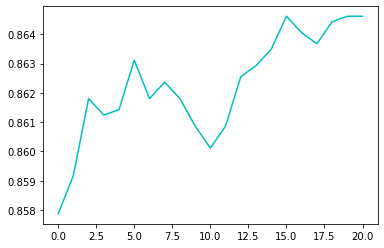

In [20]:
hnd2, = plt.plot(acc_co2al2,'c',label='Co2AL')